In [2]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import sys
import os
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
training_set, training_set_metadata = pd.read_csv("Data/training_set.csv"), pd.read_csv("Data/training_set_metadata.csv")

In [4]:
training_set.shape

(1421705, 6)

In [5]:
training_set_metadata.shape

(7848, 12)

In [6]:
# Filter datasets if it necessary into galactic or extragalactic data
metadata_galactic = training_set_metadata.loc[training_set_metadata["hostgal_photoz"] == 0,:]
metadata_extragalactic = training_set_metadata.loc[training_set_metadata["hostgal_photoz"] != 0,:]

id_objs_galactic = metadata_galactic["object_id"].values.tolist()
id_objs_extragalactic = metadata_extragalactic["object_id"].values.tolist()

## Filter into galactic data
# Filter galactic objects
training_set = training_set[training_set["object_id"].isin(id_objs_galactic)]
training_set_metadata = metadata_galactic

print(training_set.shape)
print(training_set_metadata.shape)

(400574, 6)
(2325, 12)


In [7]:
unique_obj_IDs = np.unique(training_set["object_id"].values)
unique_times = np.sort( np.unique(training_set["mjd"].values) )
unique_passbands = np.sort( np.unique(training_set["passband"].values) )
total_min_time, total_max_time = training_set["mjd"].min(), training_set["mjd"].max()

In [8]:
max_length = 500

In [9]:
data_object_list, data_label_list = [], []
# Iterate over all objects
#for i in tqdm(range(unique_obj_IDs.shape[0])):
for i in tqdm(range(10)):
    # Specify an object
    try:
        obj_id = unique_obj_IDs[i]
        # Filter the dataframe for that object. Force ordering of the dataframe in ascending order in time ("mjd" column)
        DF_obj_id = training_set.loc[training_set["object_id"] == obj_id].sort_values("mjd")
        label = int(training_set_metadata.loc[training_set_metadata["object_id"] == obj_id]["target"].values)
        # Generate a dataframe for that object with 3 columns: "mjd", "flux", "flux_error".
        new_times = np.sort(np.array(np.unique(DF_obj_id["mjd"]).tolist() + np.linspace( total_min_time, total_max_time, max_length - np.unique(DF_obj_id["mjd"]).shape[0] ).tolist()))
        output_passband = pd.DataFrame( index = range(new_times.shape[0]), columns = range(3) )
        output_passband.columns = ["mjd", "flux", "flux_err"]
        output_passband["mjd"] = new_times

        output_passband_list = []
        # Iterate over the passbands
        for p in range(unique_passbands.shape[0]):
            ## Specify a passband
            passband = unique_passbands[p]
            DF_obj_id_filter_passband = DF_obj_id.loc[DF_obj_id["passband"] == passband]
            # Extract indices where the full temporal sequence is included within the particular times of the object.
            A = output_passband["mjd"].values
            B = DF_obj_id_filter_passband["mjd"].values
            mask = np.isin(A, B)
            selected_rows = output_passband.loc[mask]
            # Modify the selected rows with the replacement DataFrame
            output_passband.loc[mask, ["flux", "flux_err"]] = DF_obj_id_filter_passband[["flux", "flux_err"]].values
            # Fill the non-selected rows with zeros
            output_passband.loc[~mask, ["flux", "flux_err"]] = 0
            output_passband_list.append( output_passband.values )
        output_passband_list = np.expand_dims( np.transpose(np.stack(output_passband_list), (2,1,0) ), axis = 0 )
        data_object_list.append(output_passband_list)
        data_label_list.append(label)
    except:
        pass
data_object_list = np.vstack(data_object_list)
data_label_list = np.reshape(np.array(data_label_list), (-1,1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 41.38it/s]


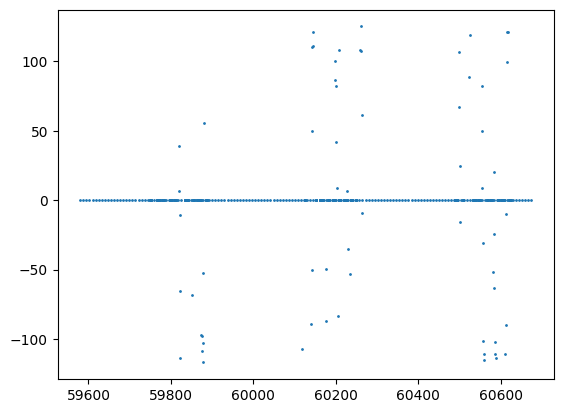

In [10]:
plt.scatter(data_object_list[0,0,:,0], data_object_list[0,1,:,0], s = 1)
plt.show()

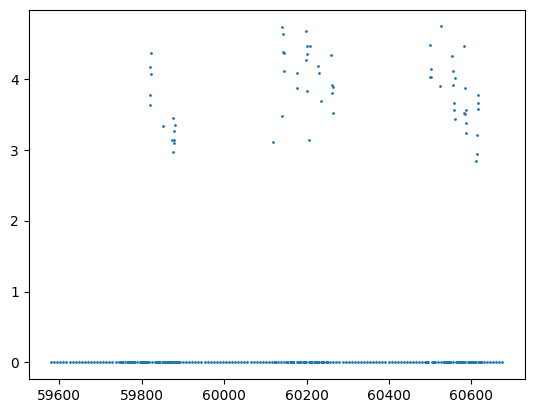

In [16]:
plt.scatter(data_object_list[0,0,:,0], data_object_list[0,2,:,0], s = 1)
plt.show()

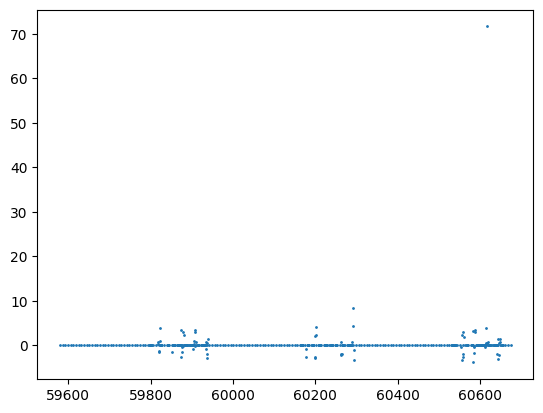

In [11]:
plt.scatter(data_object_list[1,0,:,0], data_object_list[1,1,:,0], s = 1)
plt.show()

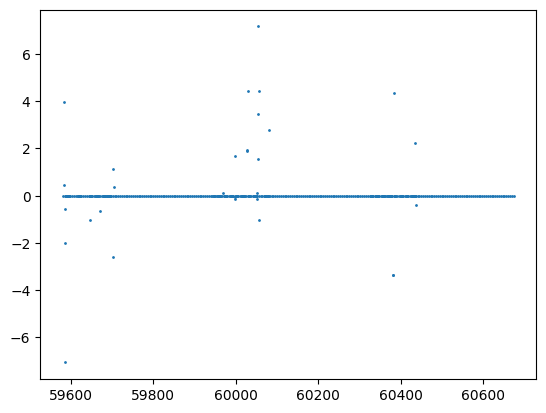

In [12]:
plt.scatter(data_object_list[2,0,:,0], data_object_list[2,1,:,0], s = 1)
plt.show()

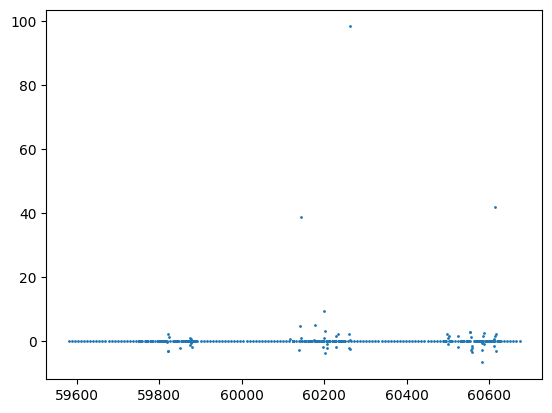

In [13]:
plt.scatter(data_object_list[3,0,:,0], data_object_list[3,1,:,0], s = 1)
plt.show()

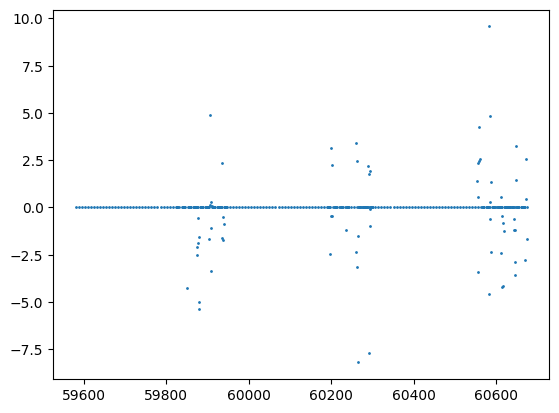

In [14]:
plt.scatter(data_object_list[4,0,:,0], data_object_list[4,1,:,0], s = 1)
plt.show()

In [11]:
# Split datasets into training, validation and test sets
random.seed(666)
integer_list = list( range( data_object_list.shape[0] ) )
random.shuffle(integer_list)
## Define the size of each of the three new lists
size_training = int(len(integer_list) * 0.75)
size_validation = int(len(integer_list) * 0.05)
size_test = int(len(integer_list) * 0.2)

X_training, Y_training = data_object_list[:size_training], data_label_list[:size_training]
X_val, Y_val = data_object_list[size_training:size_training+size_validation], data_label_list[size_training:size_training+size_validation]
X_test, Y_test = data_object_list[size_training+size_validation:], data_label_list[size_training+size_validation:]

print(X_training.shape, Y_training.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(1741, 3, 5000, 6) (1741, 1)
(116, 3, 5000, 6) (116, 1)
(465, 3, 5000, 6) (465, 1)


In [15]:
# Export datasets
hf = h5py.File("Data/ZeroFilling_galactic_data.h5", "w")

hf.create_dataset( "X_training", data = X_training.astype(float) )
hf.create_dataset( "Y_training", data = Y_training.astype(float) )

hf.create_dataset( "X_val", data = X_val.astype(float) )
hf.create_dataset( "Y_val", data = Y_val.astype(float) )

hf.create_dataset( "X_test", data = X_test.astype(float) )
hf.create_dataset( "Y_test", data = Y_test.astype(float) )

hf.close()